In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn import preprocessing
from itertools import product
from scipy import interpolate, stats
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib import animation
import math
from matplotlib.patches import Polygon


In [2]:
# Finish google drive integration: organize it so no longer need to pull test cases and transfer them constantly
# better saving name system once merged to distnguish ?
# make a quick little code for navigating back from a directory when doing test cases
# Sort code structure and do test cases
# work on outline for paper
# Push commits for sonication station
# QD updates 

In [3]:
%matplotlib inline

In [4]:
# Load data as a dataframe, 
path1 = r"C:\Users\Edwin\Downloads\test_df"
# data = data[::3] # to select at random, rdm num gen and then select from there. 

In [5]:
def load_datadf(path):
    df = pd.read_csv(path) 
    return df
def apply_column_filter(df, column_name, min=None, max=None): 
    pass

def standardize_training(data_list):
    data_reshaped = data_list[:, np.newaxis]
    scaler = preprocessing.RobustScaler().fit(data_reshaped)
    data_scaled = scaler.transform(data_reshaped)
    
    return data_scaled, scaler

def create_product_mesh(x1,x2):
    x1x2 = np.array(list(product(x1, x2)))
    x1_expanded = x1x2[:,0][:,0]
    x2_expanded = x1x2[:,1][:,0]
    return x1x2

def create_hull(x1,x2, graph = False):# inputs must be (1,n)
    hull_1 = x1[:,0]
    hull_2 = x2[:,0]
    hull_2d_points = np.asarray([hull_1, hull_2]).T
    hull = ConvexHull(hull_2d_points)
    
    if graph == True:
        for simplex in hull.simplices:
            plt.plot(hull_2d_points[simplex, 0], hull_2d_points[simplex, 1], 'k-')
    
    return hull

def point_in_hull(hull,x1,x2,graph=False):
    hull_path = Path(hull_2d_points[hull.vertices])
    if hull_path.contains_point((x1,x2)) == True:
        if graph == True:
            plt.plot(x1,x2,'o',c='r')
        return True
    else:
        return False

In [6]:
data = load_datadf(path1)
data = data[data['400.0nm'] < 0.2] 

absorbance_400 = np.asarray(pd.to_numeric(data['400.0nm'] , errors='coerce')[1:-1])
comp1 = np.asarray(pd.to_numeric(data['Component 1 wtf'] , errors='coerce')[1:-1]) # -1 removes the blank
comp2 = np.asarray(pd.to_numeric(data['Component 2 wtf'] , errors='coerce')[1:-1]) 
comp3 = np.asarray(pd.to_numeric(data['Component 3 wtf'] , errors='coerce')[1:-1])
comp4 = np.asarray(pd.to_numeric(data['Component 4 wtf'] , errors='coerce')[1:-1])
comp5 = np.asarray(pd.to_numeric(data['Component 5 wtf'] , errors='coerce')[1:-1])

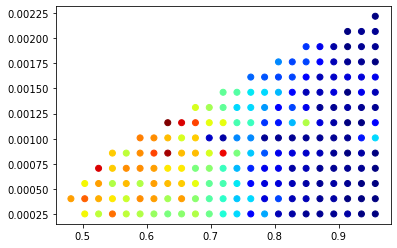

In [7]:
# load and standardize data
x1_training = comp4
x2_training = comp3
y_training = absorbance_400

x1_training_scaled, x1_scaler = standardize_training(x1_training)
x2_training_scaled, x2_scaler = standardize_training(x2_training)
y_training_scaled, y_scaler = standardize_training(y_training)
x1x2_training_scaled = np.asarray([x1_training_scaled[:,0], x2_training_scaled[:,0]]).T

# set min/max
x1_sct_min = min(x1_training_scaled) + min(x1_training_scaled)*0.2
x1_sct_max = max(x1_training_scaled) + max(x1_training_scaled)*0.2
x2_sct_min = min(x2_training_scaled) + min(x2_training_scaled)*0.2
x2_sct_max = max(x2_training_scaled) + max(x2_training_scaled)*0.2

plt.scatter(x1_training, x2_training, c = y_training, cmap='jet')

In [8]:
# Create the model and fit the data 
kernal = C(1, (1e-1, 1e3)) * RBF(1, (1e-3, 1e3)) 
gpmodel = GaussianProcessRegressor(kernel=kernal, n_restarts_optimizer=10,alpha=0.05, normalize_y=True) # random_state=42
gpmodel.fit(x1x2_training_scaled, y_training_scaled)

GaussianProcessRegressor(alpha=0.05, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10, normalize_y=True)

In [9]:
# test data is inherently scaled given the inputs, if not then would need to rescale
x1_test = np.linspace(x1_sct_min,x1_sct_max,100)
x2_test = np.linspace(x2_sct_min,x2_sct_max,100)
x1x2_test = create_product_mesh(x1_test, x2_test)

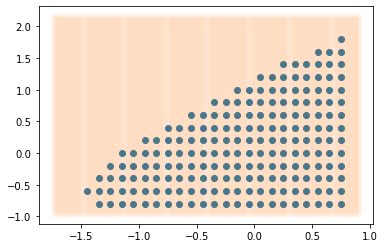

In [10]:
# verifying test arrays and resulting mesh are in range of test data
plt.scatter(x1_training_scaled, x2_training_scaled)
plt.scatter(x1x2_test[:,0][:,0], x1x2_test[:,1][:,0], alpha = 0.03)

In [11]:
# Run the test data through and convert results back from standardized to original units
x1_test_ex = x1x2_test[:,0][:,0]
x2_test_ex = x1x2_test[:,1][:,0]
x1x2_test_reform = np.asarray([x1_test_ex, x2_test_ex]).T
y_pred, MSE = gpmodel.predict(x1x2_test_reform, return_std=True) 

x1_test_org = x1_scaler.inverse_transform(x1x2_test[:,0]) 
x2_test_org = x2_scaler.inverse_transform(x1x2_test[:,1])
y_pred_org = y_scaler.inverse_transform(y_pred)

In [12]:
# Select data of interst and create meshes
x1 = x1_training
x2 = x2_training
y = y_training

dim_x1_test = x1_test.shape[0] # diff
dim_x2_test = x2_test.shape[0]

x1_mesh_prep = x1_test_org
x2_mesh_prep = x2_test_org
y_mesh_prep = y_pred_org

X1 = x1_mesh_prep.reshape(dim_x2_test, dim_x1_test)
X2 = x2_mesh_prep.reshape(dim_x2_test, dim_x1_test)
Y = np.reshape(y_mesh_prep,(dim_x2_test, dim_x1_test))
print(X1.shape, X2.shape, Y.shape, y_mesh_prep.shape)

(100, 100) (100, 100) (100, 100) (10000, 1)


In [13]:
hull_1 = x1_training
hull_2 = x2_training
hull_2d_points = np.asarray([hull_1, hull_2]).T
hull = ConvexHull(hull_2d_points)

hull_indices = hull.vertices
pts = np.asarray([x1_training[:, np.newaxis],x2_training[:, np.newaxis]]).T[0]
hull_pts = pts[hull_indices, :]
p = Polygon(hull_pts , facecolor = 'k')
# figure out a better way to cut contour plots and begin classification protocol

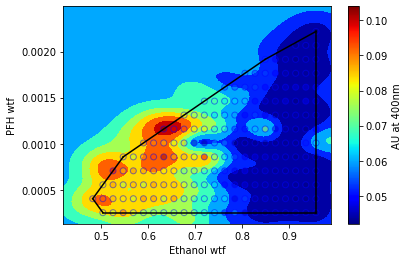

In [14]:
# Scatter plots for contour plot
fig, ax = plt.subplots(1)

vmin = min(y) 
vmax = max(y)
norm =colors.Normalize(vmin=vmin,vmax=vmax) 

mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('AU at 400nm')
# ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
# ax.set_xlim(0.4, 1)
# ax.set_ylim(0, 0.0025)
cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)

for simplex in hull.simplices:
    plt.plot(hull_2d_points[simplex, 0], hull_2d_points[simplex, 1], 'k-')
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='b',cmap='jet', alpha=0.5)



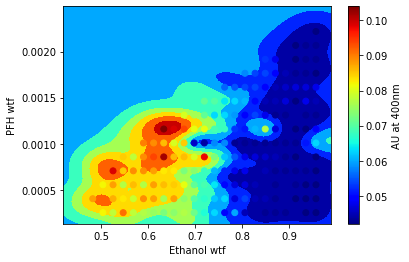

In [15]:
# Scatter plots for contour plot
fig, ax = plt.subplots(1)

vmin = min(y) 
vmax = max(y)
norm =colors.Normalize(vmin=vmin,vmax=vmax) 

mappable = ax.pcolormesh(X1,X2,Y, norm=norm, shading = 'auto',cmap='jet')
cbar = fig.colorbar(mappable)
cbar.ax.set_ylabel('AU at 400nm')
ax.scatter(x1,x2,c=y, norm=norm, edgecolors='k',cmap='jet')
ax.set_xlabel('Ethanol wtf')
ax.set_ylabel('PFH wtf')
# ax.set_xlim(0.4, 1)
# ax.set_ylim(0, 0.0025)
cs = ax.contourf(X1,X2,Y, cmap='jet', norm=norm)
ax.scatter(x1,x2,c=y, norm=norm,cmap='jet')



Text(0.5, 0, 'AU at 400nm')

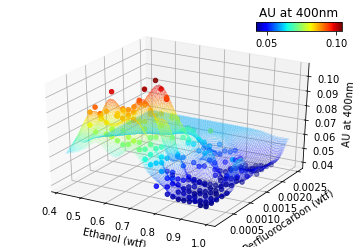

In [16]:

# populate outline with expl. of what you are doing here: What is robust scalar, fundamentals of model and limitations. 
# Contour plot, with convex hull

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1,x2,y, c=y, norm=norm, cmap='jet')
ax.plot_surface(X=X1, Y=X2, Z=Y, norm=norm, rstride=1, alpha =0.1, cstride=1, cmap='jet', linewidth=0, antialiased=False)

cbaxes = fig.add_axes([0.7, 0.85, 0.2, 0.03]) 
cb = fig.colorbar(cm.ScalarMappable(norm=norm,cmap='jet'), shrink=0.3, aspect=5, cax = cbaxes, orientation='horizontal')
cb.ax.set_title('AU at 400nm', rotation=0)

ax.set_xlabel('Ethanol (wtf)')
ax.set_ylabel('Perfluorocarbon (wtf)')
ax.set_zlabel('AU at 400nm')
# ax.set_zlim(0.0,0.1)

# ax.contourf(X1,X2,Y, zdir='z',offset=0.04, cmap='jet', norm=norm)
# for coll in cs.collections:
#     coll.set_clip_path(p)